In [1]:
import os
from graphgym.custom_graphgym.loader.protein import ProteinDataset
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
from matplotlib import pyplot as plt

<IPython.core.display.Javascript object>

In [2]:
os.chdir('/Users/cgu3/Documents/Grape-Pi')

In [3]:
dataset = ProteinDataset("data/single", numeric_columns=['protein_probability'], label_column='hard_label', rebuild=True)

Rebuilding...
Done!


In [4]:
dataset.edge_index.shape[1] 

6021584

In [5]:
dataset.y.numpy().max()

1.0

In [6]:
from torch_geometric.seed import seed_everything
seed_everything(42)

In [7]:
import copy
import os.path as osp
import time

import torch
import torch.nn.functional as F
from tqdm import tqdm

from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import SAGEConv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device)

In [8]:
from torch_geometric.nn import GCNConv
import torch_geometric.nn as nn

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super().__init__()
        self.lin1 = torch.nn.Linear(num_node_features, hidden_channels)
        self.conv1 = GCNConv(hidden_channels, hidden_channels)
        # self.conv2 = GCNConv(hidden_channels, num_classes)
        self.lin2 = torch.nn.Linear(hidden_channels, num_classes)


    def forward(self, x, edge_index):
        x = self.lin1(x)
        x = x.relu()
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.3, training=self.training)
        # x = self.conv2(x, edge_index)
        x = self.lin2(x)
        return x

model = GCN(num_node_features=dataset.num_node_features, hidden_channels=10, num_classes=1)
print(model)

GCN(
  (lin1): Linear(in_features=1, out_features=10, bias=True)
  (conv1): GCNConv(10, 10)
  (lin2): Linear(in_features=10, out_features=1, bias=True)
)


In [9]:
# create metrics tracker
import torchmetrics
from torchmetrics.classification import BinaryAUROC, BinaryAccuracy, BinaryF1Score


train_collection = torchmetrics.MetricCollection(
    BinaryAccuracy(),
    BinaryAUROC(),
    BinaryF1Score()
)

val_collection = torchmetrics.MetricCollection(
    BinaryAccuracy(),
    BinaryAUROC(),
    BinaryF1Score()
)

test_collection = torchmetrics.MetricCollection(
    BinaryAccuracy(),
    BinaryAUROC(),
    BinaryF1Score()
)

train_tracker = torchmetrics.wrappers.MetricTracker(train_collection)
val_tracker = torchmetrics.wrappers.MetricTracker(val_collection)
test_tracker = torchmetrics.wrappers.MetricTracker(test_collection)
    

In [10]:

model = GCN(dataset.num_features, 10, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()

def train(epoch):
    model.train()
        
    logits = model(data.x, data.edge_index).squeeze(-1)
    y_pred_prob = torch.nn.functional.sigmoid(logits)

    train_tracker.increment() # the start of a new epoch
    val_tracker.increment()
    test_tracker.increment()
    
    train_tracker.update(y_pred_prob[data.train_mask], data.y[data.train_mask])
    val_tracker.update(y_pred_prob[data.val_mask], data.y[data.val_mask])
    test_tracker.update(y_pred_prob[data.test_mask], data.y[data.test_mask])   
    
    loss = []
    
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        mask = mask
        loss.append(F.binary_cross_entropy_with_logits(logits[mask], data.y[mask]))
    
    optimizer.zero_grad()
    loss[0].backward()
    optimizer.step()

    return loss

In [11]:
from torch_geometric.logging import init_wandb, log

train_losses = []
val_losses = []
test_losses = []

times = []
for epoch in range(1, 301):
    start = time.time()

    train_loss, val_loss, test_loss = train(epoch)
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    test_losses.append(test_loss.item())
    
    train_metrics = train_tracker.compute()
    val_metrics = val_tracker.compute()
    test_metrics = test_tracker.compute()
    
    log(epoch=epoch, train_loss=train_loss.item(), val_loss=val_loss.item(), test_loss=test_loss.item())
    log(epoch=epoch, train_acc=train_metrics["BinaryAccuracy"].item(), val_acc=val_metrics["BinaryAccuracy"].item(), test_acc=test_metrics["BinaryAccuracy"].item())
    log(epoch=epoch, train_auc=train_metrics["BinaryAUROC"].item(), val_auc=val_metrics["BinaryAUROC"].item(), test_auc=test_metrics["BinaryAUROC"].item())
    log(epoch=epoch, train_f1=train_metrics["BinaryF1Score"].item(), val_f1=val_metrics["BinaryF1Score"].item(), test_f1=test_metrics["BinaryF1Score"].item())
    
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

epoch: 001, train_loss: 0.6892, val_loss: 0.6880, test_loss: 0.6891
epoch: 001, train_acc: 0.5503, val_acc: 0.5742, test_acc: 0.5646
epoch: 001, train_auc: 0.6550, val_auc: 0.6764, test_auc: 0.6734
epoch: 001, train_f1: 0.5766, val_f1: 0.5948, test_f1: 0.5748
epoch: 002, train_loss: 0.6886, val_loss: 0.6880, test_loss: 0.6883
epoch: 002, train_acc: 0.5583, val_acc: 0.5694, test_acc: 0.5686
epoch: 002, train_auc: 0.6628, val_auc: 0.6739, test_auc: 0.6767
epoch: 002, train_f1: 0.5804, val_f1: 0.5970, test_f1: 0.5783
epoch: 003, train_loss: 0.6880, val_loss: 0.6874, test_loss: 0.6880
epoch: 003, train_acc: 0.5658, val_acc: 0.5781, test_acc: 0.5670
epoch: 003, train_auc: 0.6697, val_auc: 0.6783, test_auc: 0.6818
epoch: 003, train_f1: 0.5832, val_f1: 0.5977, test_f1: 0.5748
epoch: 004, train_loss: 0.6878, val_loss: 0.6875, test_loss: 0.6861
epoch: 004, train_acc: 0.5723, val_acc: 0.5702, test_acc: 0.5901
epoch: 004, train_auc: 0.6673, val_auc: 0.6628, test_auc: 0.7131
epoch: 004, train_f1: 

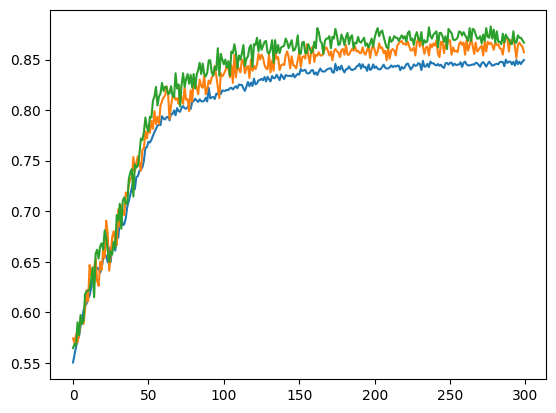

In [12]:
plt.plot(train_tracker.compute_all()['BinaryAccuracy'])
plt.plot(val_tracker.compute_all()['BinaryAccuracy'])
plt.plot(test_tracker.compute_all()['BinaryAccuracy'])
plt.show()

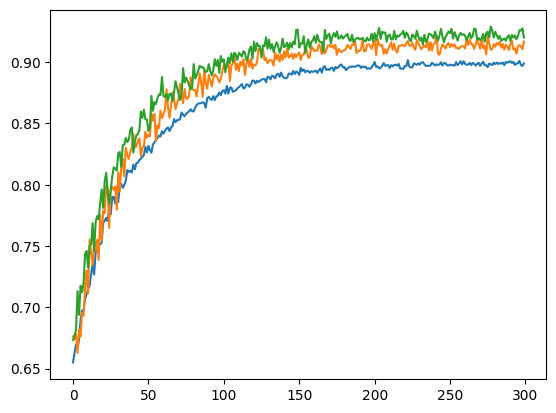

In [13]:
plt.plot(train_tracker.compute_all()['BinaryAUROC'])
plt.plot(val_tracker.compute_all()['BinaryAUROC'])
plt.plot(test_tracker.compute_all()['BinaryAUROC'])
plt.show()

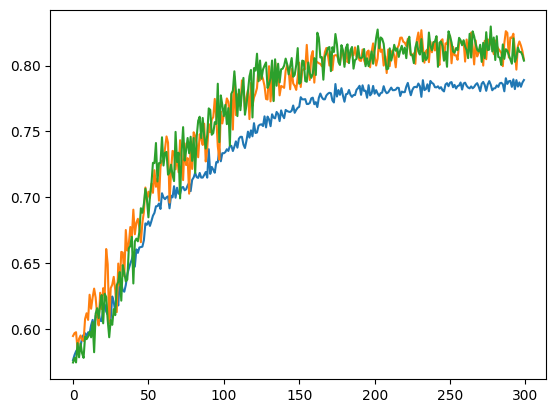

In [14]:
plt.plot(train_tracker.compute_all()['BinaryF1Score'])
plt.plot(val_tracker.compute_all()['BinaryF1Score'])
plt.plot(test_tracker.compute_all()['BinaryF1Score'])
plt.show()

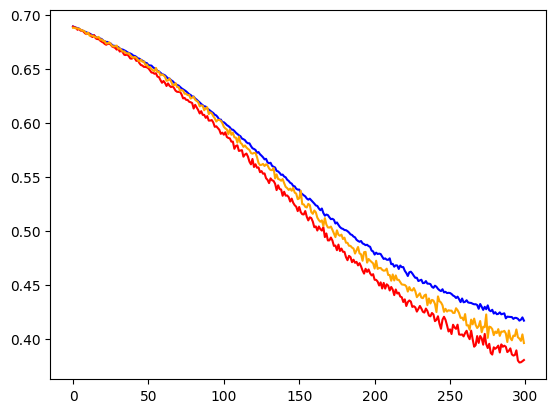

In [17]:
plt.plot(train_losses, color='b')
plt.plot(test_losses, color='r')
plt.plot(val_losses, color='orange')
plt.show()

In [16]:
train_tracker.reset_all()
val_tracker.reset_all()
test_tracker.reset_all()